# Line Extending Game 0
Here, we:
1. Introduce the "two-pixel line extending game"
2. Use reinforcement learning to learn to play the game
3. Use reinforcement learning to learn *rules* to play the game

Throughout the notebook, helper functions whose implementations are not important are factored out into a library file.

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import random
import warnings
from collections import Counter
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt

from nltk import CFG, PCFG, Nonterminal
from nltk.parse.generate import generate
from nltk.tokenize import wordpunct_tokenize
from nltk.parse.recursivedescent import RecursiveDescentParser
from nltk.tree.tree import Tree

from nsai_experiments import line_extending_game_tools as lgt

## 1: The two-pixel line extending game

### Introduction to the game

Imagine a NxN grid of pixels that can either be on (`x`) or off (`-`), represented by a NumPy Boolean array:

In [3]:
sample_grid = lgt.create_grid("""
    - - - - -
    x - - - -
    x - - x -
    - - x - -
    - - - - -
    """)
print(sample_grid)
lgt.display_grid(sample_grid)

[[False False False False False]
 [ True False False False False]
 [ True False False  True False]
 [False False  True False False]
 [False False False False False]]
- - - - -
x - - - -
x - - x -
- - x - -
- - - - -


The game is: for every "line segment" consisting of at least two contiguous `x`s, extend the segment all the way across the grid. For instance:

In [4]:
sample_start1 = lgt.create_grid("""
    - - - - - - - - - - 
    - - x - - x - - - - 
    - x - - x - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - x x - 
    - - - - - - - - - - 
    """)

sample_final1 = lgt.create_grid("""
    - - - x - - x - - - 
    - - x - - x - - - - 
    - x - - x - - - - - 
    x - - x - - - - - - 
    - - x - - - - - - - 
    - x - - - - - - - - 
    x - - - - - - - - - 
    - - - - - - - - - - 
    x x x x x x x x x x 
    - - - - - - - - - -  
    """)

lgt.display_grid(sample_start1)
print()
lgt.display_grid(sample_final1)

- - - - - - - - - -
- - x - - x - - - -
- x - - x - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - x x -
- - - - - - - - - -

- - - x - - x - - -
- - x - - x - - - -
- x - - x - - - - -
x - - x - - - - - -
- - x - - - - - - -
- x - - - - - - - -
x - - - - - - - - -
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -


The game is played in moves, where each move consists of changing one `-` to an `x`. For simplicity in this very basic version of the game, we disallow starting states that correspond to final states containing line segments not part of a line. For instance, this is disallowed:

In [5]:
bad_start = lgt.create_grid("""
    - - - - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - - - - -
    - - - - - - x x - -
    - - - - - - - - - -
    """)

bad_final = lgt.create_grid("""
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    - - x - - - - - - -
    x x x x x x x x x x
    - - x - - - - - - -
    """)

lgt.display_grid(bad_start)
print()
lgt.display_grid(bad_final)

- - - - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - x x - -
- - - - - - - - - -

- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
- - x - - - - - - -
x x x x x x x x x x
- - x - - - - - - -


because its final state contains several diagonal line segments not part of lines. For the two-pixel version, this means that, with a few exceptions, lines cannot touch each other. This rule gives our game the useful property that if grid A can be transformed into grid B with one move, a solution for grid B plus that one move is a solution for grid A.

### A First Human Solution

With this convenient modification, an intuitive solution to the game is: whenever you see a line segment, extend it on one of the ends if possible; repeat until no more moves are possible; then the game is solved. Here's an implementation of that:

In [6]:
"""
Takes a segment and direction and outputs the coordinates of the points on each end of the
segment that we'd want to extend
"""
def where_to_extend(segment, direction):
    (a, b), (c, d) = segment
    match direction:
        case "HORIZONTAL": return (a, b-1), (c, d+1)
        case "VERTICAL":   return (a-1, b), (c+1, d)
        case "SLOPE_DOWN": return (a-1, b-1), (c+1, d+1)
        case "SLOPE_UP":   return (a+1, b-1), (c-1, d+1)

def solve_human(unsolved_problem, timeout = 100, random_seed = 47, print_status = False):
    random.seed(random_seed)
    rows, cols = np.shape(unsolved_problem)
    answer = np.copy(unsolved_problem)
    # Each iteration is a move in the game; note that we only need to refer to the current state (not the starting state) to find the next move
    for i in range(timeout):
        # Find all possible line segments and the points we'd want to fill in to extend those segments
        segments, directions = lgt.find_all_segments(answer)
        possible_moves = [point
                              for (segment, direction) in zip(segments, directions)
                                  for point in where_to_extend(segment, direction)]
        
        # Exclude points that are off the board and points that have already been filled in
        if print_status: print(f"{len(possible_moves)} initial possible moves... ", end = "")
        possible_moves = list(filter(lambda point: 0 <= point[0] < rows and 0 <= point[1] < cols, possible_moves))
        if print_status: print(f"down to {len(possible_moves)} due to out of bounds... ", end = "")
        possible_moves = list(filter(lambda point: not answer[point[0], point[1]], possible_moves))
        if print_status: print(f"down to {len(possible_moves)} due to already filled in")
        
        # End or choose a random move from the possible points
        if len(possible_moves) == 0:
            if print_status: print(f"Success after {i+1} iterations!")
            return answer
        my_move = random.choice(possible_moves)
        answer[my_move] = True
    if print_status: print(f"Timed out after {timeout} iterations")
    return answer

lgt.display_grid(sample_start1)
human_answer = solve_human(sample_start1, print_status = True)
lgt.display_grid(human_answer)

assert np.array_equal(human_answer, sample_final1)

- - - - - - - - - -
- - x - - x - - - -
- x - - x - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - x x -
- - - - - - - - - -
6 initial possible moves... down to 6 due to out of bounds... down to 6 due to already filled in
8 initial possible moves... down to 7 due to out of bounds... down to 5 due to already filled in
10 initial possible moves... down to 9 due to out of bounds... down to 5 due to already filled in
12 initial possible moves... down to 11 due to out of bounds... down to 5 due to already filled in
14 initial possible moves... down to 12 due to out of bounds... down to 4 due to already filled in
16 initial possible moves... down to 14 due to out of bounds... down to 4 due to already filled in
18 initial possible moves... down to 15 due to out of bounds... down to 3 due to already filled in
20 initial possible moves... down to 16 due to out of bounds... down to 2 due to already filled in
22 initial po

Obviously this is not the most efficient solution — we are starting completely from scratch every iteration and, for most of the game, most of the candidate moves are already filled in — but it is easy to understand. Let's generate some (problem, solution) pairs and test that the algorithm works:

In [7]:
lgt.display_grid(lgt.generate_problem(10, 10, 2, 2, 2)[0])

- - - - - - - - - -
- - x - - - - x - -
- x - x - - - - - x
x - - - - - - - x -
- - - - - - - x - -
- - - - - - x - - -
- x - - - - - x - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -


In [8]:
random.seed(47)
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    assert np.array_equal(solve_human(problem), solution)

### Another Human Solution

The approach above seems simple, but it's actually built upon some facts we already knew — most notablly, how to find segments (the `lgt.find_all_segments` helper function). Let's implement an even simpler solution. We imagine an agent moving around the board, turning on all the pixels it deems necessary in a certain area before moving on. We'll give the agent a "view" of a 5x5 square centered on the active pixel (thereby encoding "for free" the knowledge that what to do for each pixel depends only on the values of pixels a maximum of 2 pixels away) and let it make two actions: turn on the pixel or move to the next cell. We'll also give the agent for free that it is not possible to activate a pixel that is already activated. We will drag this agent across the entire board until it makes a full pass without activating any pixels.

In [9]:
class RunnableGridAgent(ABC):
    """
    Initialize the agent for a grid with `n_rows` rows and `n_cols` cols; give it a state
    window of height `window_rows*2+1` and width `window_cols*2+1`.
    """
    def __init__(self, *, window_rows = 2, window_cols = 2):
        self._window_rows = window_rows
        self._window_cols = window_cols
        self._cells_traversed = 0
    
    """
    Set the grid that the agent operates on; place the agent at the top left corner. Creates
    a copy of the grid; subsequent operations will not mutate the original.
    """
    def set_grid(self, grid):
        self._n_rows, self._n_cols = grid.shape
        # Probability of moving on during exploration. Chosen so that 10% of cells
        # are filled in after max(n_rows, n_cols) full passes over the grid
        self._padded_grid = np.pad(grid, ((self._window_rows, self._window_rows), (self._window_cols, self._window_cols)))
        self._my_row = 0
        self._my_col = 0
        self._actions_taken = []
        self._action_locations = []

    "Mark the current cell as on"
    def activate_current_cell(self):
        self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col] = True

    "Read the current cell"
    def read_current_cell(self):
        return self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col]
    
    "Get the grid with whatever modifications the agent has made to it so far"
    def get_grid(self):
        return self._padded_grid[self._window_rows:-self._window_rows, self._window_cols:-self._window_cols]
    
    "Count the total number of filled cells in the current grid"
    def count_filled_cells(self):
        return np.sum(self.get_grid())
    
    "Get the current agent state as a grid centered on the active cell (which is technically not part of the state)"
    def current_state_grid(self):
        return self._padded_grid[
            self._my_row:self._my_row+self._window_rows*2+1,
            self._my_col:self._my_col+self._window_cols*2+1]
    
    "Flatten a state grid and remove the center cell"
    def flatten_subgrid(self, subgrid):
        rows, cols = subgrid.shape
        assert rows % 2 == cols % 2 == 1
        return np.delete(subgrid.flatten(), cols*(rows//2)+cols//2)

    "Use binary to encode the current agent state as an integer for `q_table` indexing"
    def _state_grid_to_n(self, state_grid):
        tr, tc = self._window_rows*2+1, self._window_cols*2+1
        assert np.shape(state_grid) == (tr, tc)
        without_center_cell = self.flatten_subgrid(state_grid)
        return without_center_cell.dot(2**np.arange(tr*tc-1)[::-1])
    
    "Apply the real policy to the state grid `s` to produce an action"
    @abstractmethod
    def real_policy(self, s):
        raise NotImplementedError()
    
    "Move the agent to its next position on the board; wrap around at the end"
    def increment_position(self):
        self._my_col += 1
        if self._my_col >= self._n_cols:
            self._my_row += 1
            self._my_col = 0
        if self._my_row >= self._n_rows:
            self._my_row = 0
        self._cells_traversed += 1
    
    "Perform a step with the given policy (defaults to real)"
    def step(self, policy = None, verbose = False):
        if policy is None: policy = self.real_policy
        state = self.current_state_grid()
        
        # If the current cell is already filled in, move on without consulting the policy
        if self.read_current_cell():
            action = 0
            if verbose: print("Moving on as active cell is already filled in")
        else:
            action = policy(state)
            self._actions_taken.append((self._state_grid_to_n(state), action))
            self._action_locations.append((self._my_row, self._my_col))  # surprise tool that will help us later
            if verbose: print(f"Policy evaluates to action {action}")
        
        if action:
            self.activate_current_cell()
        else:
            self.increment_position()
        if verbose: print(f"Position is now {(self._my_row, self._my_col)}")
        return action
    
    "Get the number of cells traversed so far"
    def get_cells_traversed(self):
        return self._cells_traversed
    
    "Provide a single number that captures how well we did against a true answer grid"
    def evaluate_goodness(self, answer_grid):
        # A cell counts against us if its true value differs from the predicted value -- that's xor
        return -np.sum(np.abs(answer_grid ^ self.get_grid()))
    
    """
    Run the agent on the grid `problem` using the real policy; stop when the agent has made
    a full pass over the grid without filling any cells or when `timeout` steps have been
    made
    """
    def run(self, problem, timeout = 100_000):
        self.set_grid(problem)
        n_cells = self._n_rows*self._n_cols
        i_last_updated = -1
        filled_cells = self.count_filled_cells()
        for i in range(timeout):
            self.step(self.real_policy)
            new_filled_cells = self.count_filled_cells()
            if new_filled_cells > filled_cells:
                i_last_updated = i
            if i-i_last_updated >= n_cells:
                return self.get_grid()
            filled_cells = new_filled_cells
        warnings.warn("Run timed out without finishing")
        return self.get_grid()
    
    "`run` the agent and return its performance"
    def test(self, problem, solution, timeout = 100_000):
        self.run(problem, timeout = timeout)
        return self.evaluate_goodness(solution)


For the human solution, we implement the following `real_policy`, which encodes all the pairs of cells that imply a segment that should be extended at the active cell:

In [10]:
class HumanAgent(RunnableGridAgent):
    def real_policy(self, s):
        return (s[0, 2] and s[1, 2]) \
            or (s[0, 4] and s[1, 3]) \
            or (s[2, 4] and s[2, 3]) \
            or (s[4, 4] and s[3, 3]) \
            or (s[4, 2] and s[3, 2]) \
            or (s[4, 0] and s[3, 1]) \
            or (s[2, 0] and s[2, 1]) \
            or (s[0, 0] and s[1, 1])

We test:

In [11]:
human_agent = HumanAgent()

random.seed(47)
for i in range(100):
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    assert np.array_equal(human_agent.run(problem), solution)
    assert human_agent.test(problem, solution) == 0  # equivalently

## 2: A Reinforcement Learning Player

### Traditional RL

Now let's use traditional reinforcement learning to teach an agent how to play the game. The development of this RL agent, inspired by Q-learning, turned out to require some iteration, so I factored that process out into `line_extending_trad_rl.ipynb`. Here, I'll describe the more or less successful design I ended up with.

We keep the formulation of an agent moving around the board, making decisions about an active pixel based on the 5x5 grid around it. The agent's policy is represented by a table where the rows are each possible state — all $2^{5*5-1} = 16,777,216$ of them — the columns are each possible action — either fill in the active pixel or move on — and the values are the quality of taking that action given that state. (In practice, we'll use two tables so that we can normalize values by the number of times they were trained.) For training, we'll use an exploration policy that initially makes random decisions biased towards the "move on" action and starts to follow the real policy closer and closer as training proceeds. We'll consider the training agent done with a given grid when it has activated the same number of pixels as are activated in the answer and then made a full pass over the grid after that. We will then compare the agent-generated grid to the solution grid and use the value of each pixel to update the weights that influenced that pixel (an earlier approach that reduced the difference between the agent-generated grid and the solution grid to a single number was not successful, or trained too slowly to demonstrate its success).


In [12]:
class TrainableGridAgent(RunnableGridAgent):
    """
    Initialize the agent for a grid with `n_rows` rows and `n_cols` cols; give it a state
    window of height `window_rows*2+1` and width `window_cols*2+1`; call `random_source` for
    a source of randomness.
    """
    def __init__(self, *, window_rows = 2, window_cols = 2, random_source = random.random):
        super().__init__(window_rows = window_rows, window_cols = window_cols)
        self._random_source = random_source
    
    def set_grid(self, grid):
        super().set_grid(grid)
        self._exploration_bias = 1 - 0.1/max(self._n_rows, self._n_cols)

    "Apply the exploration policy to the state grid `s` to produce an action"
    def exploration_policy(self, s):
        if self._random_source() < self._exploration_rate:
            return int(self._random_source() >= self._exploration_bias)
        return self.real_policy(s)

    "Gets called at the end of a call to `train` to update the model"
    @abstractmethod
    def update_model(self, solution):
        raise NotImplementedError()

    """
    Set the agent loose on the grid `problem` using the exploration policy with the given
    `exploration_rate`; use the grid `solution` to update the weights
    """
    def train(self, problem, solution, exploration_rate = 1.0, verbose = False):
        self.set_grid(problem)
        self._exploration_rate = exploration_rate
        while self.count_filled_cells() < np.sum(solution):
            self.step(self.exploration_policy)
        for i in range(self._n_rows*self._n_cols):
            self.step(self.exploration_policy)
        if verbose:
            print(f"Completed in {self._cells_traversed} steps with {len(self._actions_taken)} exploratory actions taken")
            print(f"{np.count_nonzero(self.get_grid() == solution)} matches out of {self._n_rows*self._n_cols}")
        self.update_model(solution)
        return self.get_grid()


In [13]:
# Created from the successful agent we ended up with in `line_extending_trad_rl.ipynb`
class WorkingTraditionalAgent(TrainableGridAgent):
    def __init__(self, *, window_rows = 2, window_cols = 2, random_source = random.random):
        super().__init__(window_rows = window_rows, window_cols = window_cols, random_source = random_source)
        # PERF might be better to store these together for better caching performance
        # Rows are state, cols are action (0 = move on, 1 = fill in), vals are q-value numerator
        self._q_table = np.zeros((2**((window_rows*2+1)*(window_cols*2+1)-1), 2), dtype=np.int64)
        # Rows are state, cols are action, vals are # of times encountered in training data
        self._times_encountered = np.zeros_like(self._q_table)
    
    "Apply the real policy to the state grid `s` to produce an action"
    def real_policy(self, s):
        idx = self._state_grid_to_n(s)
        q_row = self._q_table[idx]
        te_row = self._times_encountered[idx]
        with np.errstate(invalid = "ignore"): q_quotient = q_row/te_row
        if len(q_quotient[np.isnan(q_quotient)]) == len(q_quotient):
            warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
            return 0
        elif len(q_quotient[np.isnan(q_quotient)]) > 0:
            warnings.warn("Encountered situation where some option lacks training data")
            q_quotient[np.isnan(q_quotient)] = -np.inf  # Never choose the option that hasn't been trained
        return np.argmax(q_quotient)
    
    "Update weights based on how our solution differs from the true solution"
    def update_model(self, solution, *, pass_reward = 10, pass_penalty = -1, fill_reward = 100, fill_penalty = -100):
        self._normalized_q = None
        actions_taken = np.array(self._actions_taken)  # Two columns: _state_grid_to_n, action (0 or 1)
        action_locations = np.array(self._action_locations)  # Two columns: row, col
        for irow in range(self._n_rows):
            for icol in range(self._n_cols):
                # All the decisions that happened at this cell (two columns: state n, action)
                relevant_actions = actions_taken[(action_locations[:, 0] == irow) & (action_locations[:, 1] == icol)]
                yes_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 1]  # state ns where action is 0
                no_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 0]  # state ns where action is 1
                predicted = self.get_grid()[irow, icol]
                actual = solution[irow, icol]
                match (predicted, actual):
                    case (np.True_, np.False_):  # false positive
                        # If we said yes and real was no, reward all nos, penalize the yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._q_table[yes_indices, 1] += fill_penalty
                        self._times_encountered[no_indices, 0] += 1
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.True_, np.True_):  # true positive
                        # If we said yes and real was yes, nothing for nos, reward the yes
                        self._q_table[yes_indices, 1] += fill_reward
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.False_, np.False_):  # true negative
                        # If we said no and real was no, reward all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._times_encountered[no_indices, 0] += 1
                    case (np.False_, np.True_):  # false negative
                        # If we said no and real was yes, penalize all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_penalty
                        self._times_encountered[no_indices, 0] += 1
                    case _:
                        assert False, "Failed to match any case"

To see how this works, we'll feed the agent a fake source of randomness to control its behavior:

In [14]:
def fake_random_source(l):
    it = iter(l)
    return lambda: next(it)

r = fake_random_source([0.0, 1.0])
print(r())
print(r())

0.0
1.0


So if we train it like this:

In [15]:
test_grid = lgt.create_grid("""
    - - - - - -
    - x - - - -
    - - x - - -
    - - - - - -
    - - - - - -
    - - - - - -
    """)
test_answer = lgt.create_grid("""
    x - - - - -
    - x - - - -
    - - x - - -
    - - - x - -
    - - - - x -
    - - - - - x
    """)

# Each time the exploration policy is called, randomness is used (a) to determine whether to
# act randomly or follow the real policy and (b) if acting randomly, how to act. Here we
# tell it to always act randomly, to make a full pass without activating any cells, to
# activate four cells, and to make another full pass without activating any cells.
test_agent = WorkingTraditionalAgent(random_source = fake_random_source([0.0, 0.0]*34 + [0.0, 1.0]*4 + [0.0, 0.0]*30))
test_agent.train(test_grid, test_answer, verbose = True)
lgt.display_grid(test_agent.get_grid())

Completed in 75 steps with 68 exploratory actions taken
30 matches out of 36
x x x x - -
- x - - - -
- - x - - -
- - - - - -
- - - - - -
- - - - - -


we would expect moving on without activating to be encouraged at (1, 0) and discouraged at (3, 3), then activating the cell to be encouraged at (0, 0) and (once (0, 0) is activated) discouraged at (0, 1):

In [16]:
test_agent.set_grid(test_grid)

for coords in [(1, 0), (3, 3), (0, 0), (0, 1)]:
    test_agent._my_row, test_agent._my_col = coords
    print(test_agent._q_table[test_agent._state_grid_to_n(test_agent.current_state_grid())])
    if coords == (0, 0): test_agent.activate_current_cell()

[10  0]
[-1  0]
[  0 100]
[   0 -100]


Great. Here's training the agent on a few thousand grids (takes about 12m on my machine):

In [17]:
random.seed(47)
test_data = [lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4)) for i in range(100)]

trad_agent = WorkingTraditionalAgent()
random.seed(0)
grids_per_step = 1_000
n_steps = 50
trad_progress = []

def test_agent(agent, test_data = test_data):
    scores = Counter()
    for problem, solution in test_data:
        scores.update([agent.test(problem, solution)])
    return scores

for j in range(n_steps):
    trad_progress.append(test_agent(trad_agent)[0])  # Keep track of the number of grids the agent gets perfectly
    # Fully random exploration at the beginning of training, fully follow the real policy at the end
    exploration_rate = 1 - j/n_steps
    print(f"Starting training step {j} with an exploration rate of {exploration_rate}", flush = True)
    for i in range(grids_per_step):
        problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
        trad_agent.train(problem, solution, exploration_rate = exploration_rate)
trad_progress.append(test_agent(trad_agent)[0])
print("Done!")

Starting training step 0 with an exploration rate of 1.0


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_49124/2331923233.py:18: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_49124/2331923233.py:21: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


Starting training step 1 with an exploration rate of 0.98
Starting training step 2 with an exploration rate of 0.96
Starting training step 3 with an exploration rate of 0.94
Starting training step 4 with an exploration rate of 0.92
Starting training step 5 with an exploration rate of 0.9
Starting training step 6 with an exploration rate of 0.88
Starting training step 7 with an exploration rate of 0.86
Starting training step 8 with an exploration rate of 0.84
Starting training step 9 with an exploration rate of 0.8200000000000001
Starting training step 10 with an exploration rate of 0.8
Starting training step 11 with an exploration rate of 0.78
Starting training step 12 with an exploration rate of 0.76
Starting training step 13 with an exploration rate of 0.74
Starting training step 14 with an exploration rate of 0.72
Starting training step 15 with an exploration rate of 0.7
Starting training step 16 with an exploration rate of 0.6799999999999999
Starting training step 17 with an explor

And testing:

Final performance:


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_49124/2331923233.py:21: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_49124/2331923233.py:18: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


Counter({np.int64(0): 88,
         np.int64(-1): 6,
         np.int64(-2): 2,
         np.int64(-15): 1,
         np.int64(-14): 1,
         np.int64(-5): 1,
         np.int64(-3): 1})

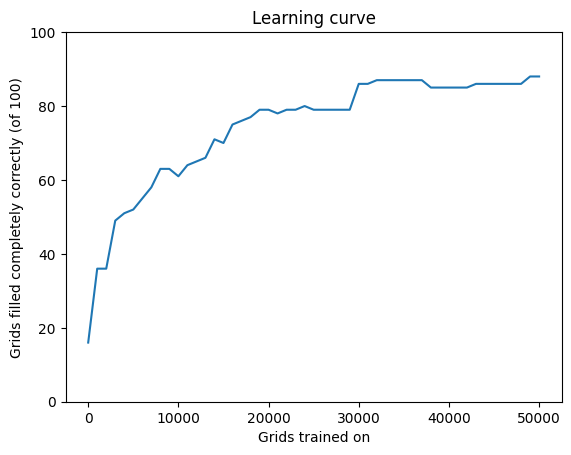

In [18]:
plt.title("Learning curve")
plt.xlabel("Grids trained on")
plt.ylabel("Grids filled completely correctly (of 100)")
plt.ylim([0, 100])
plt.plot(range(0, n_steps*grids_per_step+1, grids_per_step), trad_progress)

print(f"Final performance:")
display(test_agent(trad_agent))

On this amount of training, our agent is able to get a perfect score in roughly 90% of games. Training for longer improves this (see `line_extending_trad_rl.ipynb`), and probably some tuning of hyperparameters could also help. But for now, let's move on to another way of solving this problem.

### A Neural Player

For now, see `line_extending_neural.ipynb`. TODO summarize here.

## 3: Learning the Rules

We again work under the agent with a 5x5 view framework. We define a *rule* as a statement of the form "if this list of cells is filled in and this list of cells is not filled in, fill in the central cell." Cells in the cell list are specified as a row and a column in the 5x5 view. A *ruleset* is a list of rules with the semantic "fill in the central cell if any of these rules say to do so." Here, we will develop a context-free grammar that can produce rules, demonstrate the success of an agent with a human-written ruleset in this grammar, then train an agent to play the game with a ruleset as its policy — thus learning rules along the way.

### Grammar and parsing

Here is an NLTK grammar that generates rules:

In [19]:
grammar = CFG.fromstring("""
    S -> "if_filled" CellList "and_empty" CellList "then_activate"
    CellList -> "[" Cell "]" CellList |
    Cell -> "R" NonCentralNumber "C" AnyNumber | "R" CentralNumber "C" NonCentralNumber
    AnyNumber -> NonCentralNumber | CentralNumber
    NonCentralNumber -> "0" | "1" | "3" | "4"
    CentralNumber -> "2"
    """)

In [20]:
some_rules = [" ".join(x) for x in generate(grammar, depth = 6)]
display(some_rules[:5])

['if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 0 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 1 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 3 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 4 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] then_activate']

Note that we have hardcoded the idea that the central cell `[ R 2 C 2 ]` is invalid, but there is no elegant way to encode in the *grammar* that cells should not be duplicated in each list, or that cells that appear in the "if_filled" list should not appear in the "and_empty" list. In other words, it is possible to have rules that are grammatical but unpragmatic.

This is an LL(1) language, so it can be parsed by a recursive descent parser:

In [21]:
parser = RecursiveDescentParser(grammar)
parsed = parser.parse(wordpunct_tokenize(some_rules[1]))
print(next(parsed))

(S
  if_filled
  (CellList
    [
    (Cell R (NonCentralNumber 0) C (AnyNumber (NonCentralNumber 0)))
    ]
    (CellList
      [
      (Cell R (CentralNumber 2) C (NonCentralNumber 0))
      ]
      (CellList )))
  and_empty
  (CellList
    [
    (Cell R (NonCentralNumber 0) C (AnyNumber (NonCentralNumber 0)))
    ]
    (CellList
      [
      (Cell R (CentralNumber 2) C (NonCentralNumber 1))
      ]
      (CellList )))
  then_activate)


Here we walk the parse tree to "compile" the cell lists into Python data structures for further use:

In [22]:
def compile_cell(cell: Tree):
    _, row, _, col = cell
    # row, col at this point might be primitive or composite, but in all cases the number is at the end
    return int(row.leaves()[-1]), int(col.leaves()[-1])

def compile_cell_list(cl_tree: Tree):
    if len(cl_tree) == 0: return []
    _, first, _, rest = cl_tree
    return [compile_cell(first)] + compile_cell_list(rest)

def compile_rule_string(rule_string):
    root, = parser.parse(wordpunct_tokenize(rule_string))
    _, cl_tree1, _, cl_tree2, _ = root
    return compile_cell_list(cl_tree1), compile_cell_list(cl_tree2)

display(some_rules[1])
display(compile_rule_string(some_rules[1]))

'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 1 ] then_activate'

([(0, 0), (2, 0)], [(0, 0), (2, 1)])

### Executing rules

This function takes a ruleset in compiled form and executes it on a subgrid:

In [56]:
def execute_ruleset(parsed_ruleset, subgrid):
    for (if_filled, and_empty) in parsed_ruleset:
        if all([subgrid[row, col] for (row, col) in if_filled]) and all([not subgrid[row, col] for (row, col) in and_empty]):
            return True
    return False

execute_ruleset(
    [compile_rule_string("if_filled [ R 0 C 0 ] [ R 1 C 1 ] and_empty [ R 4 C 4 ] then_activate")],
    lgt.create_grid("""
        x - - - -
        - x - - -
        - - - - -
        - - - - -
        - - - - -
    """)
    )

True

Using this, we can directly translate the logic from `HumanAgent` above into the new language and execute it:

In [38]:
class PredefinedRulesetAgent(RunnableGridAgent):
    def __init__(self, ruleset, *, window_rows = 2, window_cols = 2):
        super().__init__(window_rows = window_rows, window_cols = window_cols)
        self._ruleset = ruleset
    def real_policy(self, s):
        return execute_ruleset(self._ruleset, s)

In [40]:
predefined_ruleset_agent = PredefinedRulesetAgent([compile_rule_string(s) for s in [
            "if_filled [ R 0 C 2 ] [ R 1 C 2 ] and_empty then_activate",
            "if_filled [ R 0 C 4 ] [ R 1 C 3 ] and_empty then_activate",
            "if_filled [ R 2 C 4 ] [ R 2 C 3 ] and_empty then_activate",
            "if_filled [ R 4 C 4 ] [ R 3 C 3 ] and_empty then_activate",
            "if_filled [ R 4 C 2 ] [ R 3 C 2 ] and_empty then_activate",
            "if_filled [ R 4 C 0 ] [ R 3 C 1 ] and_empty then_activate",
            "if_filled [ R 2 C 0 ] [ R 2 C 1 ] and_empty then_activate",
            "if_filled [ R 0 C 0 ] [ R 1 C 1 ] and_empty then_activate"
        ]])

random.seed(47)
for i in range(100):
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    assert np.array_equal(predefined_ruleset_agent.run(problem), solution)
    assert predefined_ruleset_agent.test(problem, solution) == 0  # equivalently

Note that this fully correct ruleset contains only eight rules with two cells each in the "is_filled" list and never uses the "and_empty" list. It will be interesting to see whether we can automatically learn such a simple ruleset or whether we will come up with something needlessly complicated.

### Learning Rules

Here is a simple algorithm to learn a ruleset. First, let a rule be "harmless" if it never generates false positives, and let a rule be "helpful" in the context of some existing ruleset if adding that rule to the ruleset strictly reduces the number of false negatives on at least one problem. Then the algorithm is:
  1. Start with an empty ruleset
  2. Repeat the following until 100% accuracy:
     1. Generate a random candidate rule (biased towards shorter rules)
     2. Assess the candidate's harmlessness and helpfulness by measuring the performance of the ruleset with and without the candidate
        1. If the candidate is ever responsible for a false positive, it's not harmless; discard it immediately
        2. If the candidate is responsible for even one avoided false negative, it's helpful
     3. If the candidate is harmless and helpful, add it to the ruleset

Problems I foresee here:
  1. It's hard to be completely sure if a rule is harmless — what if its harm comes up in a case we just haven't tested yet?
  2. The only thing acting like regularization here is the bias towards shorter rules; there is nothing to prevent overlapping rules from being added.

To address 2, maybe there is some "pruning" we can do once we have a 100% accurate ruleset, or maybe there is a more sophisticated procedure we can follow where we evaluate several rules at a time and only add the *most* helpful, but let's worry about that later.

Code to generate random rules biased towards shorter ones:

In [32]:
"Create a probabilistic CFG where `decay` is the chance of adding another cell to the list at each step"
def create_weighted_grammar(decay):
    return PCFG.fromstring(f"""
        S -> "if_filled" CellList "and_empty" CellList "then_activate" [1]
        CellList -> "[" Cell "]" CellList [{decay}] | [{1-decay}]
        Cell -> "R" NonCentralNumber "C" AnyNumber [{20/24}] | "R" CentralNumber "C" NonCentralNumber [{4/24}]
        AnyNumber -> NonCentralNumber [0.8] | CentralNumber [0.2]
        NonCentralNumber -> "0" [0.25] | "1" [0.25] | "3" [0.25] | "4" [0.25]
        CentralNumber -> "2" [1]
        """)

"Generate a random sentence from the probabilistic CFG"
def generate_one_probabilistic(pcfg: PCFG, current_nonterminal = None):
    if current_nonterminal is None: current_nonterminal = pcfg.start()
    current_prods = list(pcfg.productions(lhs = current_nonterminal))
    selected_prod = random.choices(current_prods, weights = [prod.prob() for prod in current_prods])[0]
    result = []
    for fragment in selected_prod.rhs():
        result += generate_one_probabilistic(pcfg, fragment) if isinstance(fragment, Nonterminal) else [fragment]
    return result

random.seed(47)
for i in range(10):
    print(" ".join(generate_one_probabilistic(create_weighted_grammar(0.5))))

if_filled [ R 1 C 1 ] [ R 0 C 1 ] and_empty [ R 4 C 2 ] [ R 1 C 2 ] [ R 3 C 4 ] [ R 2 C 0 ] [ R 1 C 1 ] then_activate
if_filled and_empty then_activate
if_filled and_empty then_activate
if_filled and_empty [ R 0 C 1 ] then_activate
if_filled [ R 1 C 4 ] and_empty then_activate
if_filled [ R 2 C 3 ] [ R 2 C 4 ] [ R 4 C 4 ] [ R 2 C 1 ] and_empty then_activate
if_filled [ R 4 C 0 ] [ R 4 C 2 ] [ R 2 C 0 ] and_empty [ R 1 C 0 ] [ R 0 C 3 ] [ R 4 C 3 ] [ R 4 C 2 ] then_activate
if_filled [ R 0 C 0 ] and_empty [ R 2 C 3 ] then_activate
if_filled and_empty [ R 3 C 2 ] [ R 4 C 0 ] then_activate
if_filled [ R 4 C 3 ] and_empty [ R 4 C 0 ] [ R 0 C 0 ] [ R 1 C 3 ] then_activate


In [129]:
class LearningRulesetAgent(TrainableGridAgent):
    def __init__(self, *, window_rows = 2, window_cols = 2, random_source = random.random, rule_decay = 0.5, grids_per_rule = 5000):
        super().__init__(window_rows = window_rows, window_cols = window_cols, random_source = random_source)
        self._weighted_grammar = create_weighted_grammar(rule_decay)
        self._ruleset = []
        self._grids_per_rule = grids_per_rule
        self._regenerate_rule()
    
    "Set the `_current_rule` to a new rule"
    def _regenerate_rule(self):
        self._current_rule = compile_rule_string(" ".join(generate_one_probabilistic(self._weighted_grammar)))
        self._current_grids_tested = 0
        self._current_is_helpful = False
    
    def set_grid(self, grid):
        super().set_grid(grid)
        self._original_grid = grid

    "Act based on the current `_ruleset`"
    def real_policy(self, s):
        return execute_ruleset(self._ruleset, s)
    
    "No exploration policy, we're purely simulating what happens with the actual ruleset"
    def train(self, problem, solution, verbose = False):
        self.run(problem)
        self.update_model(solution, verbose = verbose)
        return self.get_grid()

    def update_model(self, solution, verbose = False):
        self._current_grids_tested += 1
        old_guess = self.get_grid()
        # What would have happened if the new rule had been part of the ruleset?
        new_guess = PredefinedRulesetAgent(self._ruleset + [self._current_rule]).run(self._original_grid)

        old_false_positives = np.count_nonzero(old_guess & ~solution)
        if old_false_positives > 0: warnings.warn("Encountered a false positive with the existing ruleset")
        new_false_positives = np.count_nonzero(new_guess & ~solution)
        if new_false_positives > old_false_positives:  # If harmful, reject immediately
            self._regenerate_rule()
            return
        
        old_false_negatives = np.count_nonzero(solution & ~old_guess)
        new_false_negatives = np.count_nonzero(solution & ~new_guess)
        if new_false_negatives < old_false_negatives:  # If helpful, record but keep checking harmfulness until _grids_per_rule
            self._current_is_helpful = True
        
        if self._current_grids_tested >= self._grids_per_rule:
            if self._current_is_helpful:
                if verbose: print(f"Accepting helpful rule: {self._current_rule}")
                self._ruleset.append(self._current_rule)
            self._regenerate_rule()

In [130]:
def training_session(agent, grids_per_step, n_steps):
    random.seed(0)
    progress = []

    for j in range(n_steps):
        progress.append(test_agent(agent)[0])  # Keep track of the number of grids the agent gets perfectly
        print(f"Starting training step {j}, currently have {len(agent._ruleset)} rules", flush = True)
        for i in range(grids_per_step):
            problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
            agent.train(problem, solution, verbose = True)
    progress.append(test_agent(agent)[0])
    print("Done!")
    return progress

rules_agent = LearningRulesetAgent()
progress = training_session(rules_agent, 5000, 10)

Starting training step 0, currently have 0 rules
Starting training step 1, currently have 0 rules
Starting training step 2, currently have 0 rules
Starting training step 3, currently have 0 rules
Starting training step 4, currently have 0 rules
Starting training step 5, currently have 0 rules
Accepting helpful rule: ([(4, 2), (3, 2)], [])
Starting training step 6, currently have 1 rules
Starting training step 7, currently have 1 rules
Starting training step 8, currently have 1 rules
Starting training step 9, currently have 1 rules
Accepting helpful rule: ([(2, 3), (0, 0), (2, 4)], [(1, 4), (1, 3), (0, 1), (0, 3), (0, 2)])
Done!


In [131]:
rules_agent._ruleset

[([(4, 2), (3, 2)], []),
 ([(2, 3), (0, 0), (2, 4)], [(1, 4), (1, 3), (0, 1), (0, 3), (0, 2)])]

Okay, it does seem to work, but it's very slow. What if we artificially limit rules to those with two cells in the "if_filled" section and zero in the "and_empty" section?

In [135]:
class CheatingRulesetAgent(LearningRulesetAgent):
    "Set the `_current_rule` to a new rule that is more likely to work"
    def _regenerate_rule(self):
        rule = ((), ())
        while len(rule[0]) != 2 or len(rule[1]) != 0:
            rule = compile_rule_string(" ".join(generate_one_probabilistic(self._weighted_grammar)))
        self._current_rule = rule
        self._current_grids_tested = 0
        self._current_is_helpful = False

cheating_rules_agent = CheatingRulesetAgent()
progress = training_session(cheating_rules_agent, 5000, 10)

Starting training step 0, currently have 0 rules
Starting training step 1, currently have 0 rules
Accepting helpful rule: ([(4, 2), (3, 2)], [])
Starting training step 2, currently have 1 rules
Accepting helpful rule: ([(2, 3), (2, 4)], [])
Starting training step 3, currently have 2 rules
Starting training step 4, currently have 2 rules
Starting training step 5, currently have 2 rules
Accepting helpful rule: ([(1, 2), (0, 2)], [])
Starting training step 6, currently have 3 rules
Accepting helpful rule: ([(3, 1), (4, 0)], [])
Starting training step 7, currently have 4 rules
Starting training step 8, currently have 4 rules
Accepting helpful rule: ([(2, 1), (2, 0)], [])
Starting training step 9, currently have 5 rules
Accepting helpful rule: ([(1, 3), (0, 4)], [])
Done!


In [136]:
cheating_rules_agent._ruleset

[([(4, 2), (3, 2)], []),
 ([(2, 3), (2, 4)], []),
 ([(1, 2), (0, 2)], []),
 ([(3, 1), (4, 0)], []),
 ([(2, 1), (2, 0)], []),
 ([(1, 3), (0, 4)], [])]

It finds more rules, but not *that* many more rules. This suggests that most of the time is spent validating correct rules rather than rejecting incorrect ones. Okay, back to the non-cheating version and let's just run it for a really long time:

In [137]:
long_rules_agent = LearningRulesetAgent()
progress = training_session(long_rules_agent, 25_000, 50)

Starting training step 0, currently have 0 rules
Accepting helpful rule: ([(1, 2), (0, 2)], [(2, 1)])
Starting training step 1, currently have 1 rules
Starting training step 2, currently have 1 rules
Accepting helpful rule: ([(2, 4), (2, 1), (2, 3), (0, 4), (2, 3), (2, 1), (0, 2)], [(1, 0)])
Starting training step 3, currently have 2 rules
Starting training step 4, currently have 2 rules
Starting training step 5, currently have 2 rules
Accepting helpful rule: ([(2, 4), (4, 0), (3, 1)], [])
Starting training step 6, currently have 3 rules
Accepting helpful rule: ([(0, 0), (1, 1)], [])
Starting training step 7, currently have 4 rules
Starting training step 8, currently have 4 rules
Starting training step 9, currently have 4 rules
Starting training step 10, currently have 4 rules
Accepting helpful rule: ([(3, 2), (3, 4), (4, 2)], [(4, 1)])
Starting training step 11, currently have 5 rules
Starting training step 12, currently have 5 rules
Starting training step 13, currently have 5 rules
A

In [138]:
long_rules_agent._ruleset

[([(1, 2), (0, 2)], [(2, 1)]),
 ([(2, 4), (2, 1), (2, 3), (0, 4), (2, 3), (2, 1), (0, 2)], [(1, 0)]),
 ([(2, 4), (4, 0), (3, 1)], []),
 ([(0, 0), (1, 1)], []),
 ([(3, 2), (3, 4), (4, 2)], [(4, 1)]),
 ([(3, 3), (4, 4)], []),
 ([(2, 3), (2, 4)], [(2, 0), (4, 3)]),
 ([(4, 0), (3, 1)], []),
 ([(3, 2), (4, 2)], [(3, 1)]),
 ([(1, 3), (0, 4)], [(2, 4), (3, 3)]),
 ([(2, 0), (4, 4), (2, 1)], []),
 ([(2, 0), (2, 1)], [(0, 4), (2, 4)]),
 ([(0, 4), (1, 3)], [])]

TODO it's a little worrying that `long_rules_agent` doesn't start with the same first two rules as `rules_agent` even though we're setting the random seed, track down the nondeterminism

Final performance:


Counter({np.int64(0): 94, np.int64(-2): 3, np.int64(-3): 3})

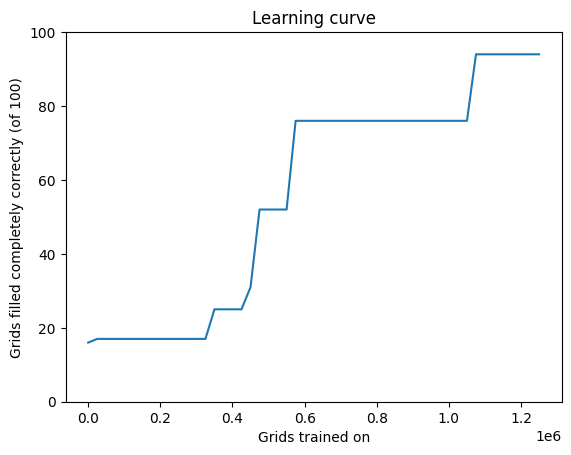

In [139]:
plt.title("Learning curve")
plt.xlabel("Grids trained on")
plt.ylabel("Grids filled completely correctly (of 100)")
plt.ylim([0, 100])
plt.plot(range(0, 50*25_000+1, 25_000), progress)

print(f"Final performance:")
display(test_agent(long_rules_agent))

It took quite a while, but we have pretty good accuracy.

How redundant are the rules in the ruleset? Here is a visualization of the ruleset where each rule is a 5x5 grid with the "is_filled" cells as `x` and the "and_empty" cells as `o`:

In [162]:
"Create a grid of -, x, and o to represent a given rule (represented in compiled form)"
def viz_rule(compiled_rule, rows = 5, cols = 5):
    is_filled, and_empty = compiled_rule
    char_grid = np.full((rows, cols), "-")
    for idx in is_filled: char_grid[idx] = "x"
    for idx in and_empty: char_grid[idx] = "o"
    return char_grid

"Use `viz_rule` to visualize a compiled ruleset. Displays `display_cols` grids side by side on each row"
def viz_ruleset(compiled_ruleset, subgrid_rows = 5, subgrid_cols = 5, display_cols = 5):
    rule_grids = [viz_rule(compiled_rule, subgrid_rows, subgrid_cols) for compiled_rule in compiled_ruleset]
    for grid_start_i in range(0, len(rule_grids), display_cols):
        for row_i in range(subgrid_rows):
            this_row = [" ".join(this_grid[row_i]) for this_grid in rule_grids[grid_start_i:grid_start_i+display_cols]]
            print("    ".join(this_row))
        print()

viz_ruleset(long_rules_agent._ruleset)

- - x - -    - - x - x    - - - - -    x - - - -    - - - - -
- - x - -    o - - - -    - - - - -    - x - - -    - - - - -
- o - - -    - x - x x    - - - - x    - - - - -    - - - - -
- - - - -    - - - - -    - x - - -    - - - - -    - - x - x
- - - - -    - - - - -    x - - - -    - - - - -    - o x - -

- - - - -    - - - - -    - - - - -    - - - - -    - - - - x
- - - - -    - - - - -    - - - - -    - - - - -    - - - x -
- - - - -    o - - x x    - - - - -    - - - - -    - - - - o
- - - x -    - - - - -    - x - - -    - o x - -    - - - o -
- - - - x    - - - o -    x - - - -    - - x - -    - - - - -

- - - - -    - - - - o    - - - - x
- - - - -    - - - - -    - - - x -
x x - - -    x x - - o    - - - - -
- - - - -    - - - - -    - - - - -
- - - - x    - - - - -    - - - - -



We can at least verify that all the rules are harmless, so problem 1 is less of an issue than I thought. It looks like at least one rule implies a superset of moves of another — a manifestation of problem 2 — which suggests that a pruning process would indeed be helpful.

For reference, here's our manual, ideal ruleset:

In [163]:
viz_ruleset([compile_rule_string(s) for s in [
            "if_filled [ R 0 C 2 ] [ R 1 C 2 ] and_empty then_activate",
            "if_filled [ R 0 C 4 ] [ R 1 C 3 ] and_empty then_activate",
            "if_filled [ R 2 C 4 ] [ R 2 C 3 ] and_empty then_activate",
            "if_filled [ R 4 C 4 ] [ R 3 C 3 ] and_empty then_activate",
            "if_filled [ R 4 C 2 ] [ R 3 C 2 ] and_empty then_activate",
            "if_filled [ R 4 C 0 ] [ R 3 C 1 ] and_empty then_activate",
            "if_filled [ R 2 C 0 ] [ R 2 C 1 ] and_empty then_activate",
            "if_filled [ R 0 C 0 ] [ R 1 C 1 ] and_empty then_activate"
        ]])

- - x - -    - - - - x    - - - - -    - - - - -    - - - - -
- - x - -    - - - x -    - - - - -    - - - - -    - - - - -
- - - - -    - - - - -    - - - x x    - - - - -    - - - - -
- - - - -    - - - - -    - - - - -    - - - x -    - - x - -
- - - - -    - - - - -    - - - - -    - - - - x    - - x - -

- - - - -    - - - - -    x - - - -
- - - - -    - - - - -    - x - - -
- - - - -    x x - - -    - - - - -
- x - - -    - - - - -    - - - - -
x - - - -    - - - - -    - - - - -

